In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('WI_Breast_Cancer.csv')

In [3]:
#rename columns
df.columns = ['id', 'class', 'thickness','uniformity of size', 'uniformity of shape', 'marginal adhesion', 'single cell size',
             'bare nuclei','bland chromatin', 'normal nucleoli', 'mitosis']

In [4]:
#check missing values
df.isnull().sum()

id                     0
class                  7
thickness              7
uniformity of size     8
uniformity of shape    8
marginal adhesion      8
single cell size       8
bare nuclei            8
bland chromatin        8
normal nucleoli        8
mitosis                8
dtype: int64

In [5]:
#drop missing values
df =df.dropna()

In [6]:
df.head()

,id,class,thickness,uniformity of size,uniformity of shape,marginal adhesion,single cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis
0,1002945,2,5.0,4.0,4.0,5.0,7.0,10.0,3.0,2.0,1
1,1015425,2,3.0,1.0,1.0,1.0,2.0,2.0,3.0,1.0,1
2,1016277,2,6.0,8.0,8.0,1.0,3.0,4.0,3.0,7.0,1
3,1017023,2,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1
4,1017122,4,8.0,10.0,10.0,8.0,7.0,10.0,9.0,7.0,1


Based on the information provided and what I see in the data set, all data are discrete inputs. ID column is not contributing to prediction, so we can get rid of it when training. Since RandonForest can take continuous inputs, so we do not need to preprocess the data. But we need to make sure all data type should be int or float.

Class is labeld 2(benign) and 4(maglignant), let's make it 0 for benign and 1 for maglignant for a more clear reading.

In [7]:
#check data types
df.dtypes

id                      object
class                   object
thickness              float64
uniformity of size     float64
uniformity of shape    float64
marginal adhesion      float64
single cell size       float64
bare nuclei            float64
bland chromatin        float64
normal nucleoli        float64
mitosis                 object
dtype: object

In [8]:
# make class to be 0 and 1
mask = df['class'] == '2'
df['class'] = np.where(mask, 1,0)

In [9]:
#convert to numerical values
df['mitosis']=pd.to_numeric(df['mitosis'], errors='coerce')

In [10]:
#clean all NaN again
df = df.dropna()

In [11]:
#final check on datatype
df.dtypes

id                      object
class                    int32
thickness              float64
uniformity of size     float64
uniformity of shape    float64
marginal adhesion      float64
single cell size       float64
bare nuclei            float64
bland chromatin        float64
normal nucleoli        float64
mitosis                float64
dtype: object

Data looks all good now. Let's check whether its an unbalanced data. 

In [12]:
from collections import Counter
print('Original dataset shape {}'.format(Counter(df['class'])))

Original dataset shape Counter({1: 457, 0: 242})


Yes, it's. Let's resample the training data it using SMOTE

In [13]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

X = df.iloc[:, 2:11]
y = df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state =0)


print('Original dataset shape {}'.format(Counter(df['class'])))
sm = SMOTE(random_state=0)
X_res, y_res = sm.fit_sample(X_train, y_train)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({1: 457, 0: 242})
Resampled dataset shape Counter({0: 345, 1: 345})


X_res, y_res are ready to split and train.

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [73]:
#entropy 
clf_entropy =DecisionTreeClassifier(criterion='entropy').fit(X_res, y_res)
y_pre_entropy = clf_entropy.predict(X_test)
acc_ent = accuracy_score(y_test, y_pre_entropy) * 100
print("Accuracy  for entropy is : {}%".format(acc_ent))

Accuracy  for entropy is : 93.14285714285714%


In [74]:
#gini 
clf_gini =DecisionTreeClassifier().fit(X_res, y_res)
y_pre_gini = clf_gini.predict(X_test)
acc_gini = accuracy_score(y_test, y_pre_gini) * 100
print("Accuracy  for entropy is : {}%".format(acc_gini))

Accuracy  for entropy is : 94.85714285714286%


Both performances are good, but let's try to tune the parameters to see whether we can improve the performance.

####  Entropy first

We test the difference in max_depth and min_samples_leaf

In [79]:
clf_entropy =DecisionTreeClassifier(criterion='entropy', max_depth =5).fit(X_res, y_res)
y_pre_entropy = clf_entropy.predict(X_test)
acc_ent = accuracy_score(y_test, y_pre_entropy) * 100
print("Accuracy  for entropy is : {}%".format(acc_ent))

Accuracy  for entropy is : 94.85714285714286%


In [80]:
clf_entropy =DecisionTreeClassifier(criterion='entropy', min_samples_leaf =6).fit(X_res, y_res)
y_pre_entropy = clf_entropy.predict(X_test)
acc_ent = accuracy_score(y_test, y_pre_entropy) * 100
print("Accuracy  for entropy is : {}%".format(acc_ent))

Accuracy  for entropy is : 94.28571428571428%


####  Gini first

We test the difference in max_depth and min_samples_leaf

In [81]:
clf_gini =DecisionTreeClassifier(max_depth =100).fit(X_res, y_res)
y_pre_gini = clf_gini.predict(X_test)
acc_gini = accuracy_score(y_test, y_pre_gini) * 100
print("Accuracy  for entropy is : {}%".format(acc_gini))

Accuracy  for entropy is : 93.71428571428572%


In [82]:
clf_gini =DecisionTreeClassifier(min_samples_leaf =3).fit(X_res, y_res)
y_pre_gini = clf_gini.predict(X_test)
acc_gini = accuracy_score(y_test, y_pre_gini) * 100
print("Accuracy  for entropy is : {}%".format(acc_gini))

Accuracy  for entropy is : 94.85714285714286%


#### Test both entropy and the gini coefficient. Which performs better and why?
For the default settings, entrophy peformances better (a little bit). 
They are two different math compuatations that contributes different splitter. However, I don't think based on the small difference in accuracy, we can say gini is always better. For the parameters I tried, entropy is better.

credit to :https://towardsdatascience.com/gini-index-vs-information-entropy-7a7e4fed3fcb

#### What are the best hyperparameter settings for both?
After tuning, we can see that entropy with max_depth =5 outperform the default model. While for gini model, the default model is the best.

In [86]:
#best entropy model
clf_entropy =DecisionTreeClassifier(criterion='entropy', max_depth = 5).fit(X_res, y_res)
y_pre_entropy = clf_entropy.predict(X_test)
acc_ent = accuracy_score(y_test, y_pre_entropy) * 100
print("Accuracy  for entropy is : {}%".format(acc_ent))

Accuracy  for entropy is : 94.85714285714286%


In [87]:
#best gini model 
clf_gini =DecisionTreeClassifier(min_samples_leaf =3).fit(X_res, y_res)
y_pre_gini = clf_gini.predict(X_test)
acc_gini = accuracy_score(y_test, y_pre_gini) * 100
print("Accuracy  for entropy is : {}%".format(acc_gini))

Accuracy  for entropy is : 94.85714285714286%


### Visualization
#### Entropy tree

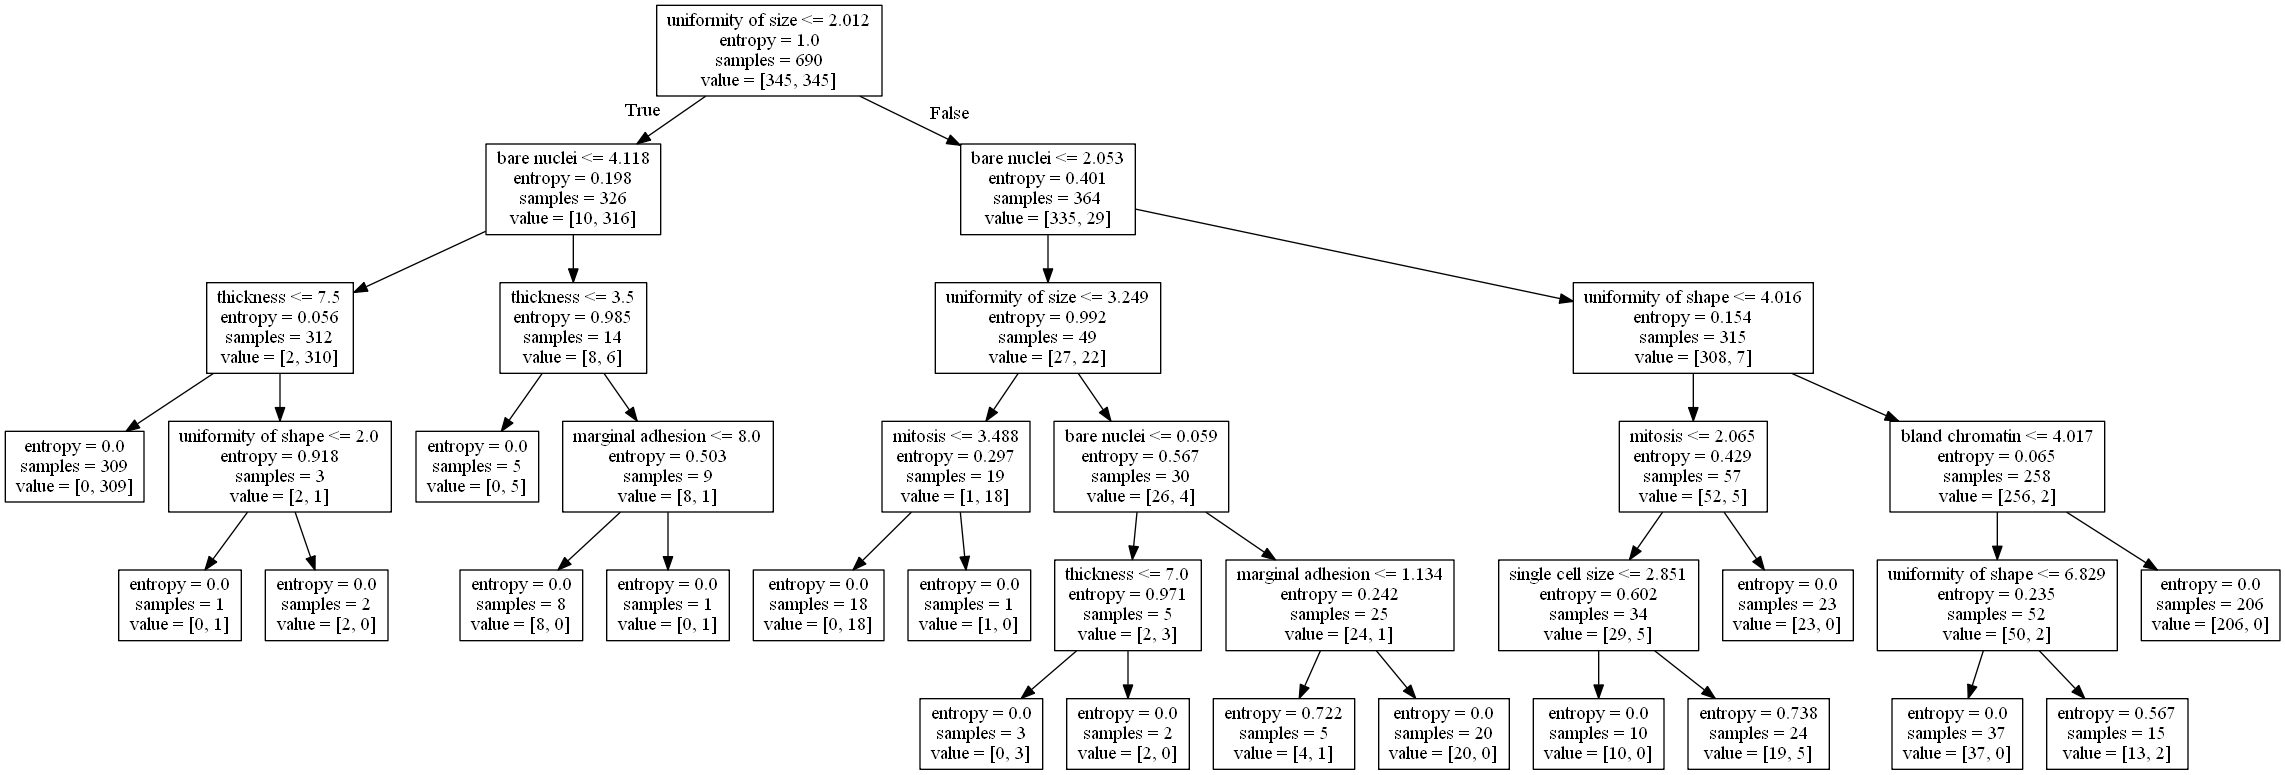

In [88]:
from graphviz import Source
from IPython.display import SVG
from sklearn import tree
from IPython.display import Image

feature_names = X_res.columns.values.tolist()

graph = Source(tree.export_graphviz(clf_entropy, out_file=None, feature_names=feature_names))

# save as png
# graph.format = 'png'
# graph.render('dtree_render',view=True)

png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

Image(png_bytes)

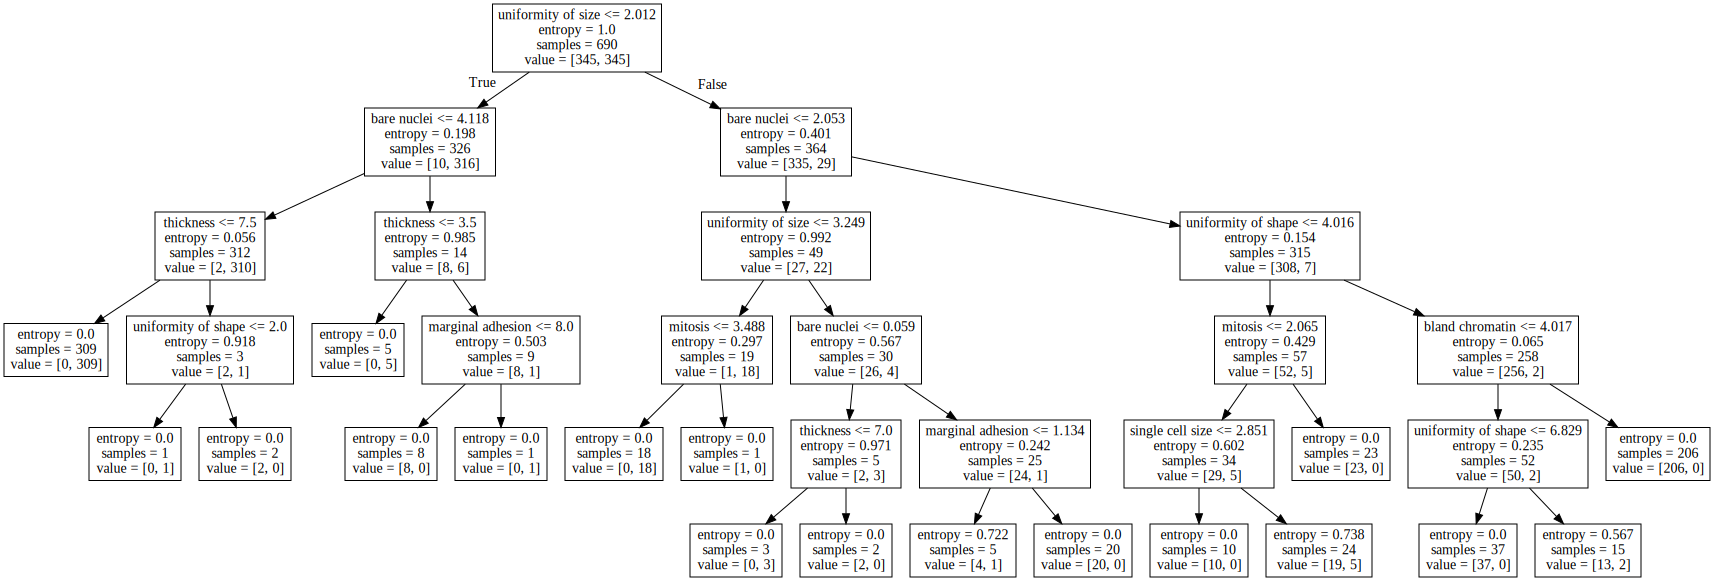

In [89]:
#view larger image
SVG(graph.pipe(format='svg'))

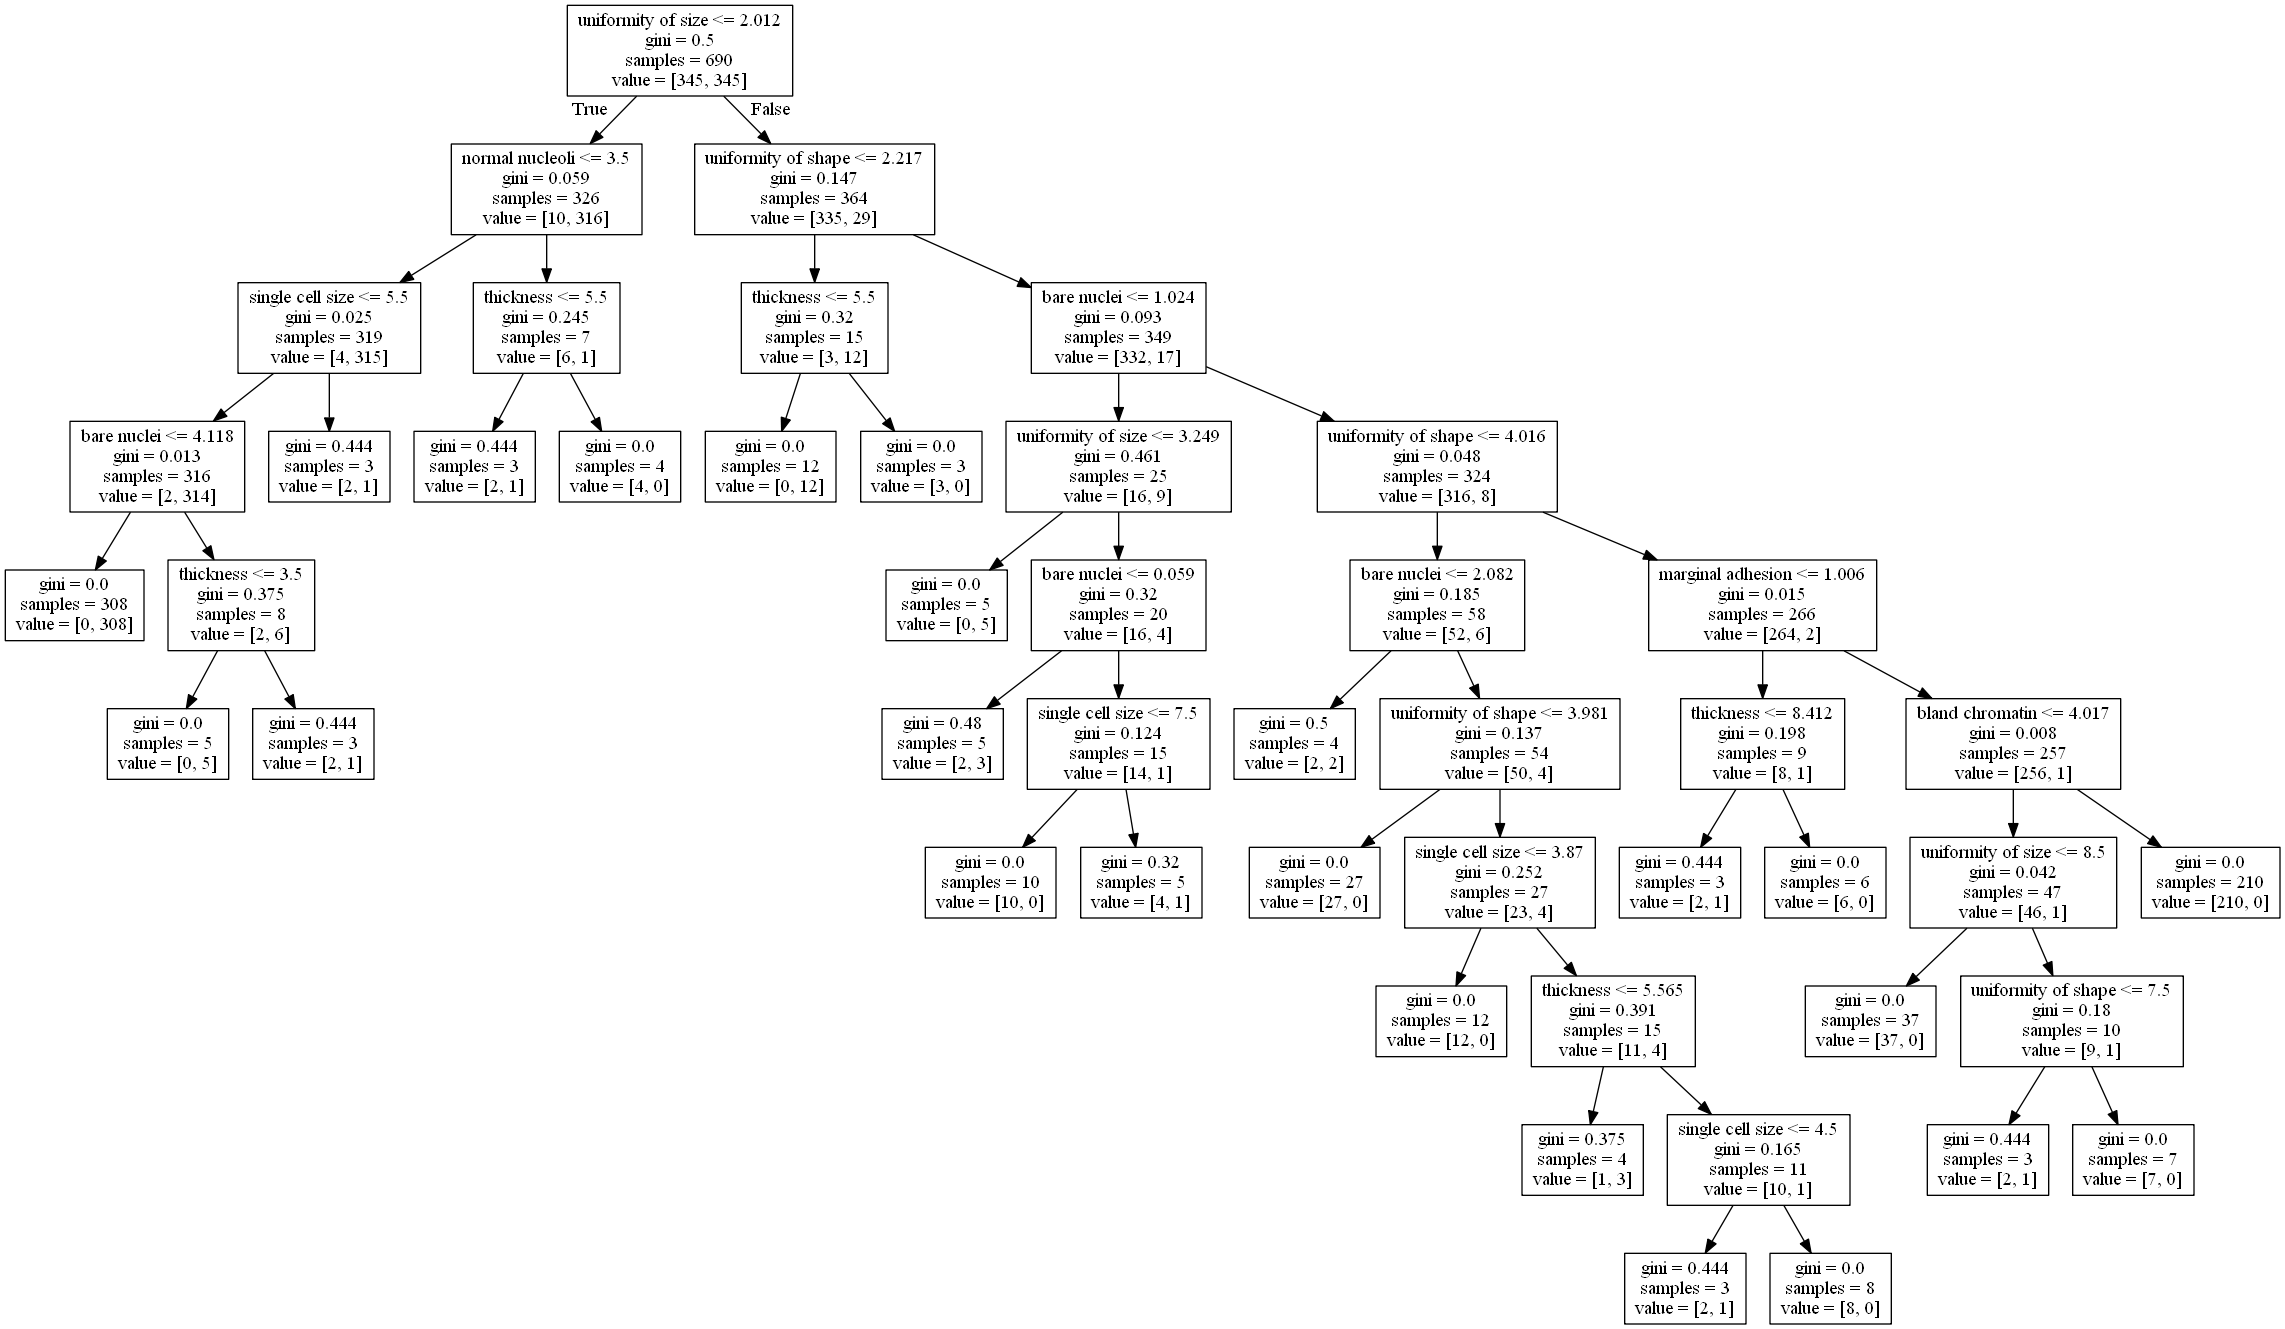

In [90]:
graph = Source(tree.export_graphviz(clf_gini, out_file=None, feature_names=feature_names))

# save as png
# graph.format = 'png'
# graph.render('dtree_render',view=True)

png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

Image(png_bytes)

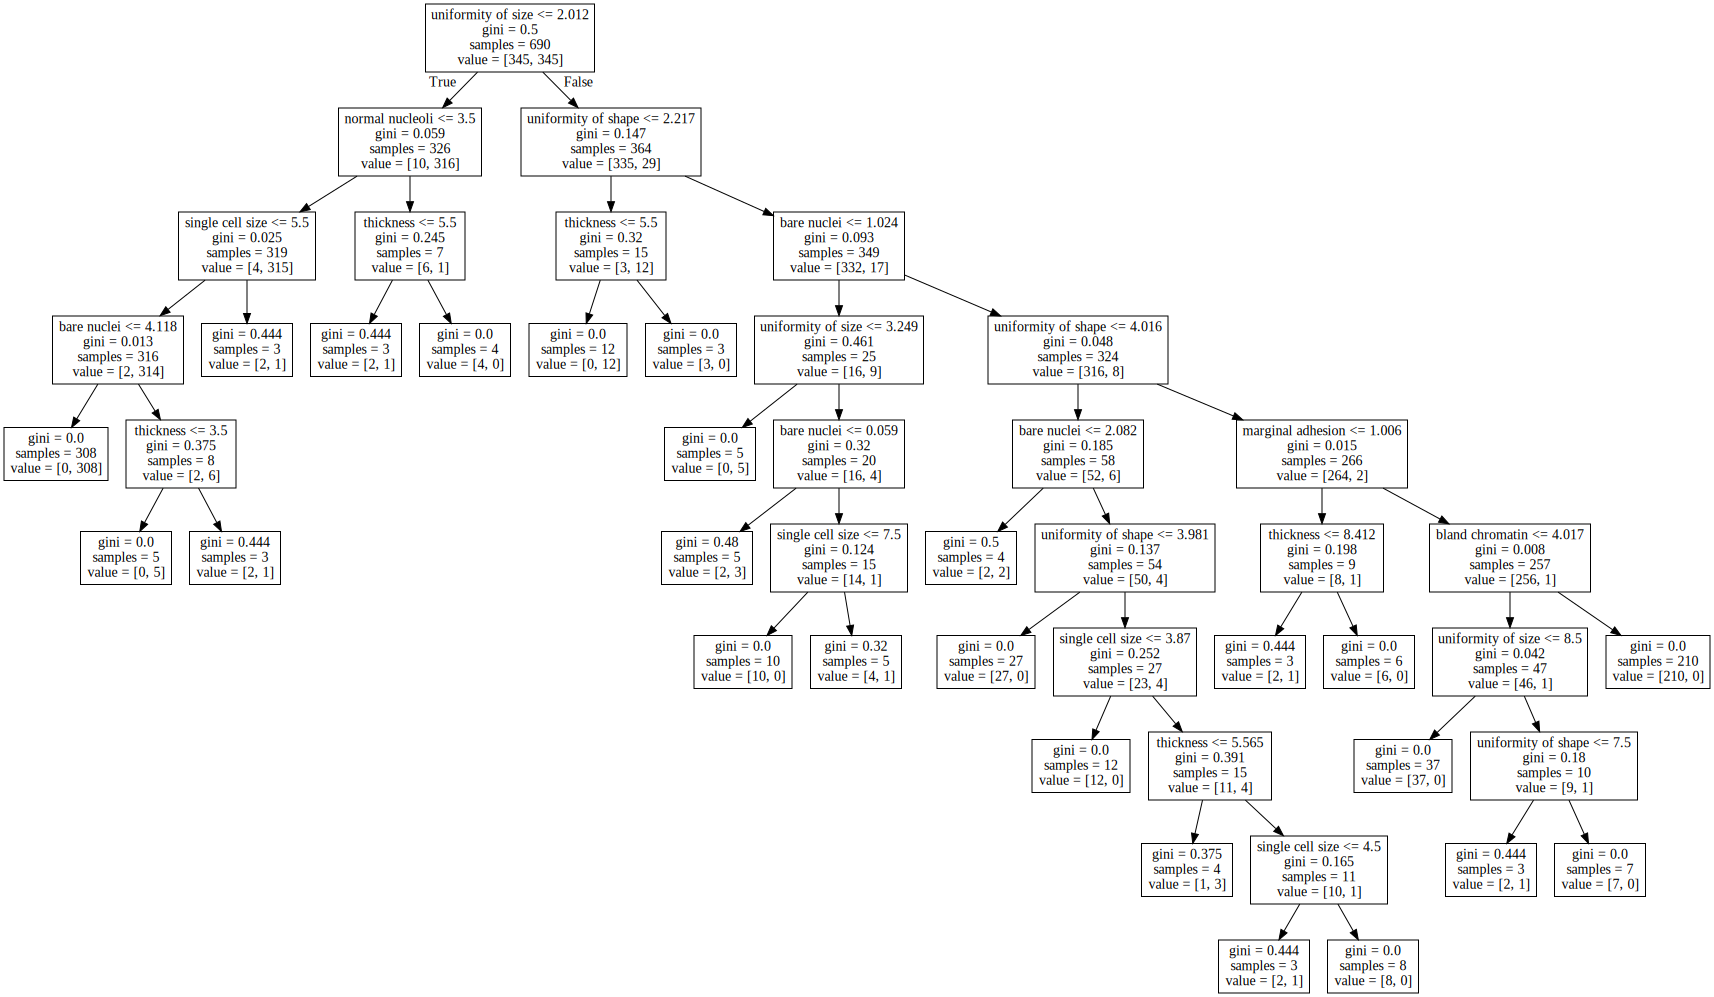

In [91]:
#view larger image
SVG(graph.pipe(format='svg'))

#### Are they same for both? Why or why not?

They are not the same overall.The one similarity is both trees start with the same splitter, size <= 2.12. 

Entropy only have depth of five, because we set it as five. While gini is default, so there is no limit on depth until all leaves are pure or until all leaves contain less than min_samples_split (which is 1).There are total 10 layers in gini. 

The reason why they are different is because they are using different criterion (algorithm). Gini is based on gini impurity and entropy is based on the information gain. 

#### Determine the AUC for the best model you can achieve. What are the precision and recal values and which might be the one you want to maximize?

In [92]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [93]:
def score(y, model_name):
    auc= roc_auc_score(y_test, y )* 100
    prec = precision_score(y_test,y) * 100
    recall = recall_score (y_test, y) * 100
    print('Scores for'+ model_name)
    print("AUC is : %.2f"% (auc))
    print("Precision is : %.2f"%(prec))
    print("Recall is : %.2f"%(recall) )          

In [94]:
score(y_pre_entropy,' entropy')

Scores for entropy
AUC is : 95.29
Precision is : 98.13
Recall is : 93.75


In [95]:
score(y_pre_gini, ' gini')

Scores for gini
AUC is : 94.94
Precision is : 97.25
Recall is : 94.64


AUC, precision and recall are calculated for both optimized models. And they are very closed. AUC is the area under the ROC curve, the value of AUC tells the ability to correctly identify the label. The higher value of ROC(max=1), the better the model is.

Precision score is calculated from TP/(TP+FP). Recall score is calculated from (TP/TP+FN). 

Recall measures the ability of a model to find all the relevant cases within a dataset, while precision measures the proportion of the data the model predicts was relevant acutally were relevant.

In our work, we have unbalanced dataset, where have more benign cases (refer to positive). The goal is to correctly classifiy the sample, that means we prefer to misclassify negative to positive instead the other way around. That means we want to have small NF, and overall, high recall socre. In this case, the gini model works a little bit better. 



credit to:
https://towardsdatascience.com/understanding-auc-roc-curve-68b2303cc9c5

https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c

#### What are the implications of using this type of machine learning algorithm for breast cancer analysis?

DecisionTree is a whitebox algorithm, we can see how classifications are made, like what's the size will be threshold to make the splits. Also, since DecisionTree can handle both categorical and numerical inputs, we don't need to do too much on preparing data set. This is classification problem, the predicton is going to be only positive and negative. The dataset only has less than 800 samples, it is a small data set. The high accuracy makes me suspect that model could be overfitting.